## LINMA1702 - Laboratoire optimisation linéaire - Question 2 : affectation de tâches

In [2]:
from scipy.optimize import linprog   # import du solveur d'optimisation linéaire à utiliser
import numpy as np                   # numpy toujours utile pour manipuler des vecteurs & matrices

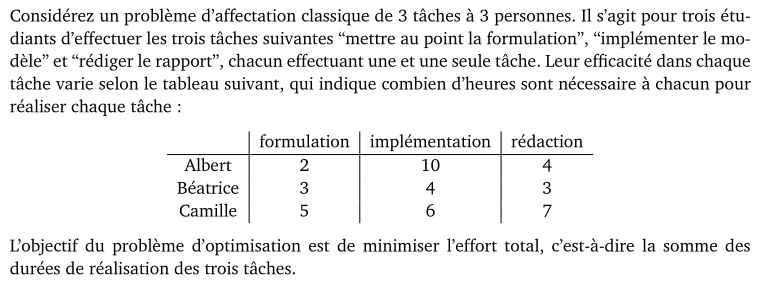

**Questions 2(a-b)** : formulez ce problème linéairement (notez que la formulation est suggérée dans les commentaires du code ci-dessous). Pour le résoudre, on va utiliser lingprog, qui est solveur d'optimisation linéaire en variables continues. On ne peut donc pas imposer aux variables d'être binaires, à la place on leur demandera d'appartenir à l'intervalle continu [0,1].

In [3]:
# Voici la formulation pour seulement 3 personnes et trois tâches :

# Le vecteur d'inconnues x contient 9 variables x_ij où 1<=i,j<=3, avec la convention suivante :
#    x_ij=1 si la personne i effectue tache j, x_ij=0 sinon

# Ces 9 variables sont rassemblées dans un vecteur comme suit : 
#    [x_11 x_12 x_13 x_21 x_22 x_23 x_31 x_32 x_33] dans cet ordre 
# (l'ordre transposé était également possible)

# Il faut à présent imposer
#   - que chaque personne effectue une tâche (trois premières contraintes)
#   - que chaque tâche est effectuée par une personne (trois dernières contraintes)

# Ceci correspond à 6 égalités linéaires, qu'on va mettre sous la forme
# d'un système linéaire A x = b où la matrice A et le vecteur b sont : 

A = [
    [1,1,1,0,0,0,0,0,0],  # pour que la somme des tâches pour la personne 1 fasse 1 : x11 + x12 + x13 = 1
    [0,0,0,1,1,1,0,0,0],  # idem personne 2
    [0,0,0,0,0,0,1,1,1],  # idem personne 3
    [1,0,0,1,0,0,1,0,0],  # pour que la somme des personnes pour la tâche 1 fasse 1 : x11 + x21 + x31 = 1
    [0,1,0,0,1,0,0,1,0],  # idem tâche 2
    [0,0,1,0,0,1,0,0,1]]  # idem tâche 3 (question : cette dernière contrainte est-elle vraiment nécessaire ?)
b = [1,1,1,1,1,1]

                                                                 
# La fonction objectif est un vecteur de taille 9 contenant les coefficients pour chaque variable :
c = [2, 10, 4, 3, 4, 3, 5, 6, 7]

# Pour rappel, si aucune borne fournie, linprog considère que x_ij >= 0 (borne inf=0, borne sup=inf)
# Est-il nécessaire d'incorporer explicitement des bornes supérieures x_ij <= 1 ?
# Non ! Expliquez pourquoi ...

res=linprog(c, A_eq=A, b_eq=b, options={"disp": False}) 
print(res.message)
print(res)

Optimization terminated successfully. (HiGHS Status 7: Optimal)
        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 11.0
              x: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00
                   1.000e+00 -0.000e+00  1.000e+00  0.000e+00]
            nit: 5
          lower:  residual: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00
                             -0.000e+00  1.000e+00 -0.000e+00  1.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  7.000e+00  2.000e+00  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              2.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf        inf        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
   

**Question 2(c)** : affichez la solution sous la forme d'une matrice, et commentez : on constate que les composantes de la solution sont ...

In [4]:
# Affichage de façon un peu plus lisible la solution, en reformant la matrice 3x3 des x_ij
# (et en supprimant les valeurs très proches de zéro du genre 1e-12)
sol_mat = np.reshape(res.x,(3,3))
print(np.array_str(sol_mat, precision=2, suppress_small=True))

[[ 1.  0.  0.]
 [ 0. -0.  1.]
 [-0.  1.  0.]]


**Question 2(d)** : généralisation à un problème à N personnes et N tâches. Codez une fonction permettant de résoudre le problème général, puis testez avec des durées aléatoires (distribution uniforme sur l'intervalle [0,1]). Estimez la valeur moyenne de la durée minimale, et commentez.

In [5]:
def affectation_optimale(matrice_durees):
    '''Calcule l'affectation optimale correspond à la matrice_couts par optimisation linéaire.'''
    # Ce modèle d'affectation classique s'écrit comme suit, pour une matrice de couts c_ij
    # Soit x_ij la variable indiquant que 
    # min              sum_ij  c_ij * x_ij
    #          tel que sum_i          x_ij = 1   pour tout j allant de 1 à N     = une tâche par personne
    #               et sum_j          x_ij = 1   pour tout i allant de 1 à N     = une personne par tâche
    #               et                x_ij >= 0  pour tout i,j allant de 1 à N
    
    N = np.size(matrice_durees, 1)     # On déduit N de la taille de la matrice des durées (supposées carrée)

    # Il faut à présent écrire les deux systèmes de N contraintes d'égalité
    # (en fait on ne gardera que N-1 égalités du second système, car il y a une redondance (cf. plus haut), 
    #  et on choisira d'omettre la dernière contrainte d'égalité du second système)
    
    # On fabrique donc une matrice A (de taille 2N-1 x N^2) et d'un vecteur b (de taille 2N-1)
    
    A = np.zeros((2*N-1, N*N))  
    for i in range(N):
        for j in range(N):
            A[i][i*N+j] = 1
    
    for i in range(N-1):
        for j in range(N):
            A[i+N][j*N+i] = 1

    # Le membre de droite b est beaucoup plus simple à écrire
    b = np.ones(2*N-1)
    
    # Et la fonction objectif s'obtient par vectorisation de la matrice des durées
    # (attention, par défaut resphape parcourt la matrice par colonne, il faut demander explicitement pour parcourir par ligne)
    c = np.reshape(matrice_durees,(1,N*N), order='F')
    
    # Résolution 
    return linprog(c, A_eq=A, b_eq=b, options={"disp": False}, method="revised simplex") 
    # où on a demandé l'utilisation d'un algorithme de type simplexe  
    # (en effet, l'algorithme par défaut, de type point intérieur, rencontre des difficultés numériques (précision) 
    #  avec certaines matrices, même en modifiant les options "cholesky" et "sym_pos"
    #  Un bon solver ne devrait pas rencontrer de telles difficultés pour des problèmes de cette (petite) taille !

In [6]:
# Calculons la moyenne de la durée optimale après pour 100 runs avec N = 10 personnes/tâches et une matrice aléatoire
def moyenne_duree_optimale(N_runs, N):
    durees = [affectation_optimale(np.random.rand(N,N)).fun for k in range(N_runs)]
    moyenne_durees = np.mean(durees)
    print(f"Moyenne des durées minimales après {N_runs} runs de taille {N}x{N} : {moyenne_durees:.4f}, " +
          f"équivalent à une durée moyenne par personne de {moyenne_durees/N:.4f}.")
moyenne_duree_optimale(10,10)

/tmp/ipykernel_5986/3302941504.py:35: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  return linprog(c, A_eq=A, b_eq=b, options={"disp": False}, method="revised simplex")


Moyenne des durées minimales après 10 runs de taille 10x10 : 1.2648, équivalent à une durée moyenne par personne de 0.1265.


**Question 2(e)** : augmentez la valeur de N : que constatez vous ?